# Time Series Analysis
## (S)ARIMA Models

In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox

import pmdarima as pm # Auto ARIMA
from sklearn.metrics import mean_squared_error

### Flights data

In [2]:
# Loading the Data
flights = sns.load_dataset('flights')
flights['date'] = pd.to_datetime(flights['year'].astype(str) + flights['month'].astype(str), format='%Y%b')
flights['log_passengers'] = np.log(flights['passengers'])
flights.set_index('date', inplace=True)

flights

,year,month,passengers,log_passengers
date,,,,
1949-01-01,1949,Jan,112,4.718499
1949-02-01,1949,Feb,118,4.770685
1949-03-01,1949,Mar,132,4.882802
1949-04-01,1949,Apr,129,4.859812
1949-05-01,1949,May,121,4.795791
...,...,...,...,...
1960-08-01,1960,Aug,606,6.406880
1960-09-01,1960,Sep,508,6.230481
1960-10-01,1960,Oct,461,6.133398


#### Is the time series stationary after the second differencing?
ARIMA cannot deal with seasonality or do seasonal differencing. We therefore try second order differencing.

In [3]:
flights['log_passengers_diff_2'] = flights.log_passengers.diff().diff()

In [4]:
adf_test = adfuller(flights.log_passengers_diff_2.dropna())
print(f'p-value: {adf_test[1]}')

p-value: 7.419304549376186e-13


Yes, the time series is stationary after the second differencing.

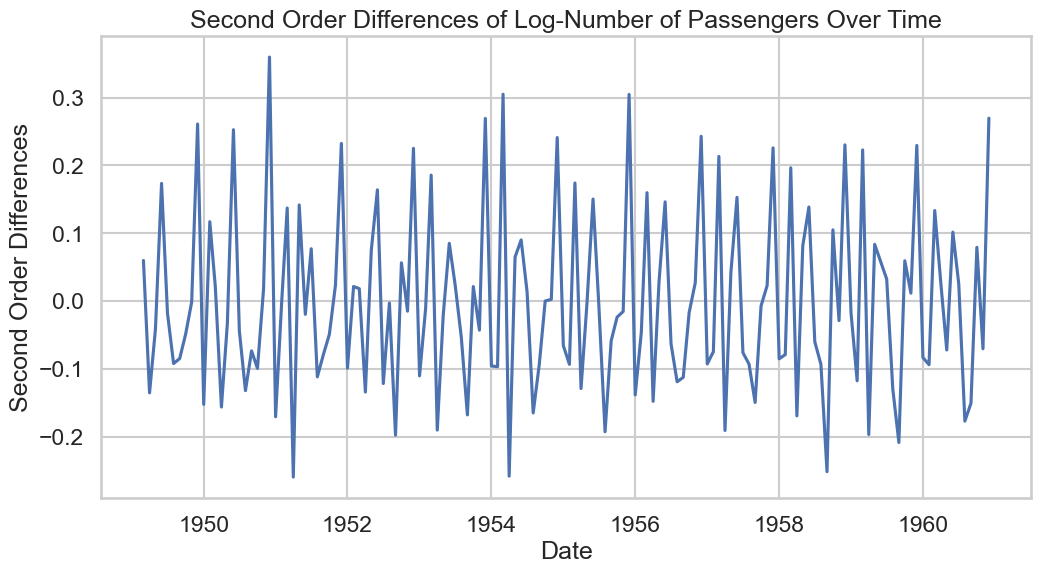

In [5]:
# Plot of Second Order Differences
sns.set_theme(style='whitegrid')
sns.set_context("talk")
plt.figure(figsize=(12, 6))
sns.lineplot(data=flights, x='date', y='log_passengers_diff_2')
plt.title('Second Order Differences of Log-Number of Passengers Over Time')
plt.xlabel('Date')
plt.ylabel('Second Order Differences')
plt.savefig('flights_diff2.png', transparent=True)
plt.show()

#### Split the data in train and test dataset

In [6]:
# Test set of two years (24 months)
train, test = pm.model_selection.train_test_split(flights, test_size=24)

In [7]:
train

,year,month,passengers,log_passengers,log_passengers_diff_2
date,,,,,
1949-01-01,1949,Jan,112,4.718499,NaN
1949-02-01,1949,Feb,118,4.770685,NaN
1949-03-01,1949,Mar,132,4.882802,0.059932
1949-04-01,1949,Apr,129,4.859812,-0.135107
1949-05-01,1949,May,121,4.795791,-0.041032
...,...,...,...,...,...
1958-08-01,1958,Aug,505,6.224558,-0.092984
1958-09-01,1958,Sep,404,6.001415,-0.251258
1958-10-01,1958,Oct,359,5.883322,0.105051


In [8]:
test

,year,month,passengers,log_passengers,log_passengers_diff_2
date,,,,,
1959-01-01,1959,Jan,360,5.886104,-0.017490
1959-02-01,1959,Feb,342,5.834811,-0.117314
1959-03-01,1959,Mar,406,6.006353,0.222836
1959-04-01,1959,Apr,396,5.981414,-0.196481
1959-05-01,1959,May,420,6.040255,0.083779
1959-06-01,1959,Jun,472,6.156979,0.057884
1959-07-01,1959,Jul,548,6.306275,0.032572
1959-08-01,1959,Aug,559,6.326149,-0.129422
1959-09-01,1959,Sep,463,6.137727,-0.208297


### ARIMA model
We use AUTO ARIMA to fit an ARIMA model with the "best" parameters (with the lowest AIC).

In [9]:
arima = pm.auto_arima(train.log_passengers,
                      start_p=1,
                      start_q=1,
                      max_p=12, max_q=12,   # maximum p and q
                      m=1,                  # period for seasonal differencing; m=1: no seasonality
                      d=2,                  # second order differencing
                      seasonal=False,   # No Seasonality
                      trace=True,
                      suppress_warnings=True, # don't want convergence warnings
                      stepwise=True
                      )

print(arima.summary())

Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.33 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=-133.649, Time=0.03 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=-142.901, Time=0.04 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=-135.648, Time=0.04 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=-152.941, Time=0.08 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=-151.680, Time=0.06 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.29 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=-154.935, Time=0.05 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=-144.900, Time=0.03 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=-153.671, Time=0.05 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=inf, Time=0.19 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=inf, Time=0.13 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=inf, Time=0.21 sec

B

#### Model Diagnostics

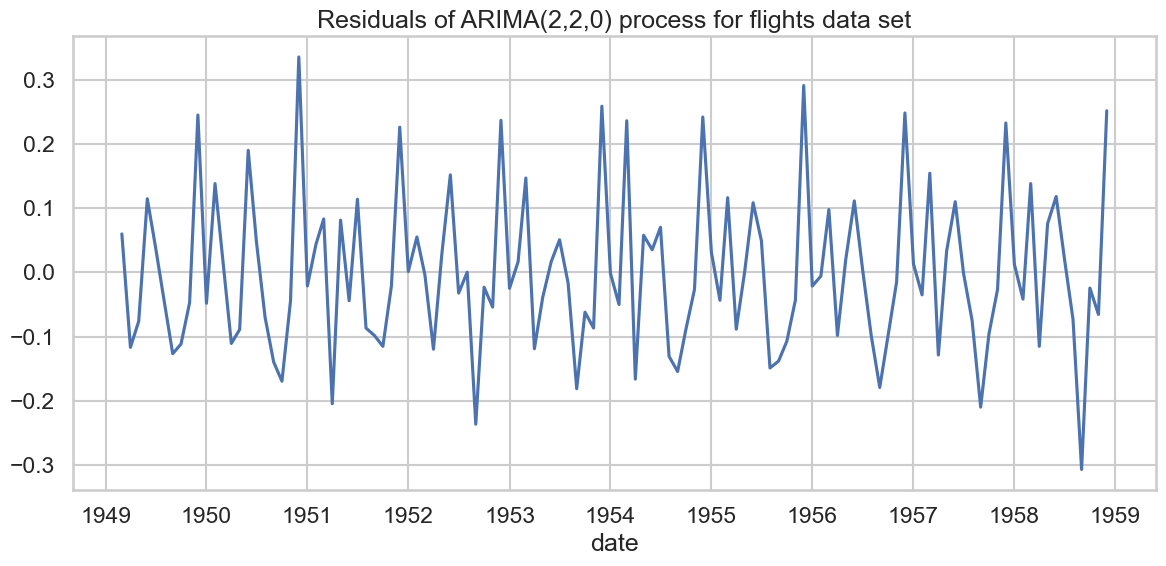

In [10]:
plt.figure(figsize=(12, 6))
sns.set_context("talk")
sns.lineplot(arima.resid()[2:])
plt.title('Residuals of ARIMA(2,2,0) process for flights data set')
# plt.xlabel('Yearly')
# plt.ylabel('Number of Passengers')
plt.tight_layout()
plt.savefig('flightsARIMA_resid.png', transparent=True)
plt.show()

ACF and PACF of residuals to check if they resemble white noise

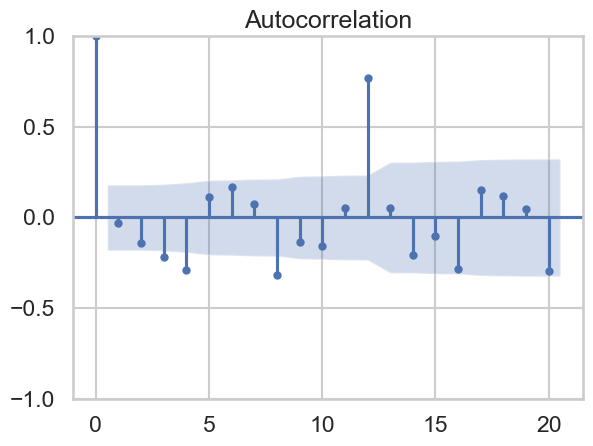

In [11]:
plot_acf(arima.resid()[2:], lags=20)
plt.tight_layout()
plt.savefig('flightsARIMA_resid_acf.png', transparent=True)
plt.show()

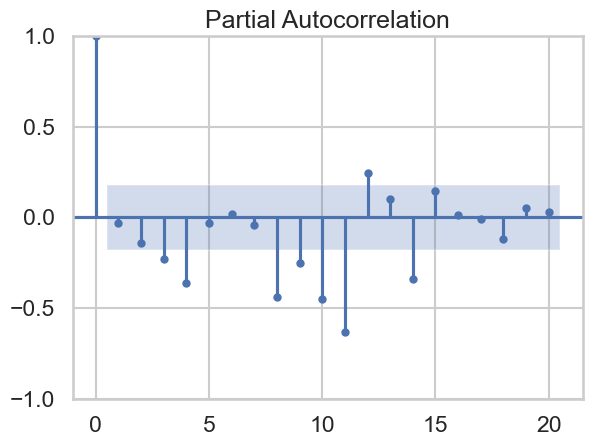

In [12]:
plot_pacf(arima.resid()[2:], lags=20)
plt.tight_layout()
plt.savefig('flightsARIMA_resid_pacf.png', transparent=True)
plt.show()

In [13]:
# Ljung-Box test of autocorrelation in residuals
acorr_ljungbox(arima.resid()[2:])

,lb_stat,lb_pvalue
1,0.095291,0.757555
2,2.559596,0.278093
3,8.360495,0.039120
4,18.865314,0.000835
5,20.409262,0.001047
6,23.936326,0.000537
7,24.621333,0.000885
8,37.519786,0.000009
9,39.988758,0.000008
10,43.225539,0.000005


The ACF and the PACF plot show that there is autocorrelation and partial autocorrelation in the residuals.  
The Ljung-Box test shows that the residuals are not independent.  
The model assumption that the residuals are white noise is therefore not fulfilled.

### SARIMA model

In [14]:
sarima = pm.auto_arima(train.log_passengers,
                      start_p=1,
                      start_q=1,
                      max_p=12, max_q=12, # maximum p and q
                      m=12,              # seasonality: 12 months
                      d=1,           # first order differencing
                      start_P=0, 
                      D=1, 
                      start_Q=0, 
                      trace=True,
                      suppress_warnings=True, # don't want convergence warnings
                      stepwise=True
                      )

print(sarima.summary())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=-362.564, Time=0.12 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-353.412, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-383.359, Time=0.25 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=-389.010, Time=0.50 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=-364.326, Time=0.07 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=-387.220, Time=0.71 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=-387.254, Time=1.24 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=-384.230, Time=0.20 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=1.86 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=-379.989, Time=0.18 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=-386.674, Time=0.40 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=-387.065, Time=0.45 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=-388.643, Time=0.26 sec
 ARIMA(1,1,2)(0,1,1)[12]             : AIC=-385.319, Time=0.80 sec
 ARIMA(0,1,1)(0,1,1)[12]

#### Model Diagnostics

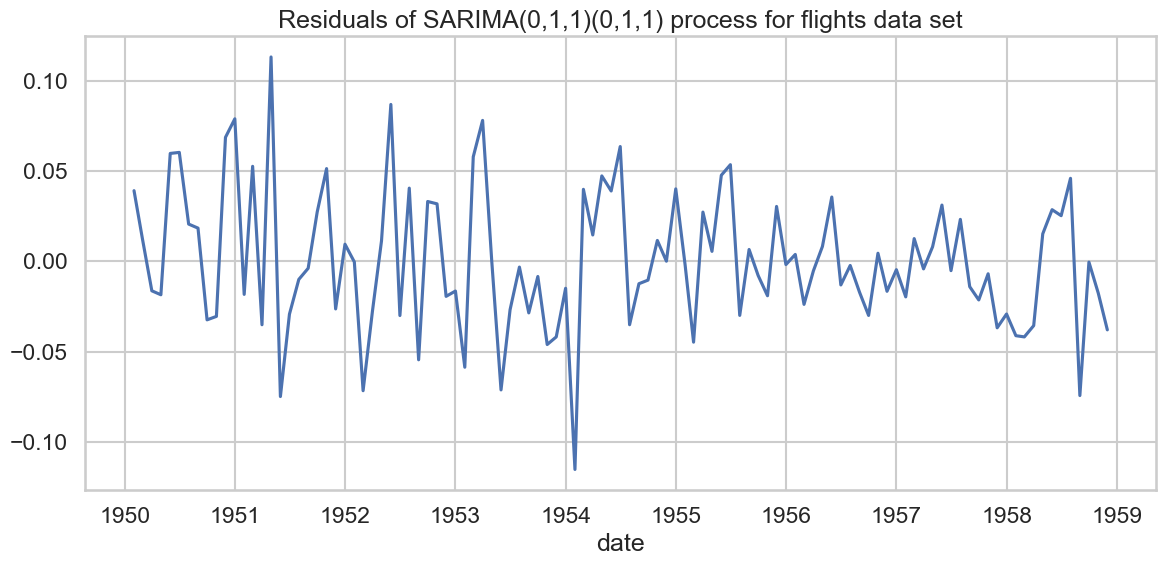

In [15]:
plt.figure(figsize=(12, 6))
sns.set_context("talk")
sns.lineplot(sarima.resid()[13:])
plt.title('Residuals of SARIMA(0,1,1)(0,1,1) process for flights data set')
plt.tight_layout()
plt.savefig('flightsSARIMA_resid.png', transparent=True)
plt.show()

ACF and PACF of residuals to check if they resemble white noise

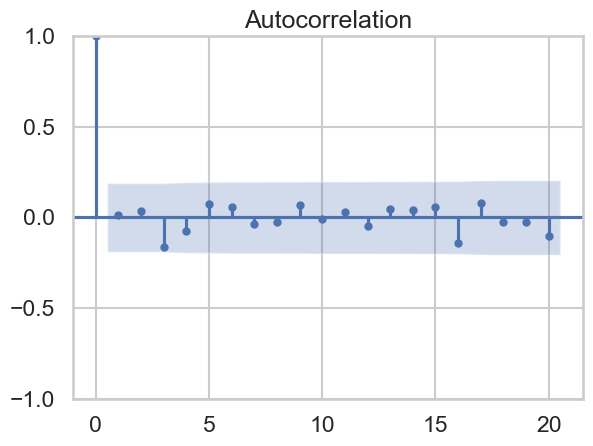

In [16]:
plot_acf(sarima.resid()[13:], lags=20)
plt.tight_layout()
plt.savefig('flightsSARIMA_resid_acf.png', transparent=True)
plt.show()

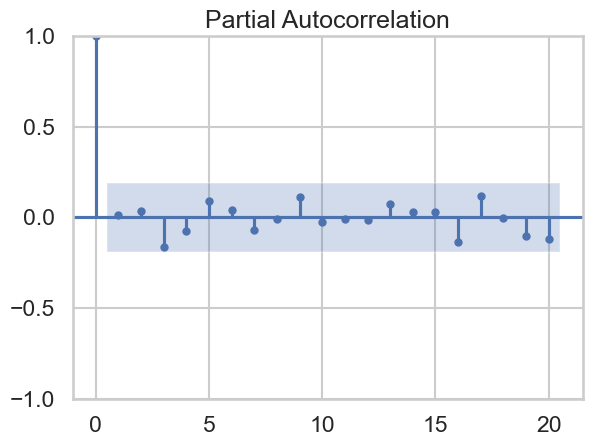

In [17]:
plot_pacf(sarima.resid()[13:], lags=20)
plt.tight_layout()
plt.savefig('flightsSARIMA_resid_pacf.png', transparent=True)
plt.show()

In [18]:
# Ljung-Box test of autocorrelation in residuals
acorr_ljungbox(sarima.resid()[13:])

,lb_stat,lb_pvalue
1,0.020388,0.886459
2,0.170508,0.918279
3,3.164998,0.366879
4,3.834138,0.428918
5,4.468191,0.484151
6,4.882134,0.559017
7,5.020671,0.657441
8,5.098546,0.746993
9,5.680095,0.771459
10,5.685088,0.840991


The diagnostic plots look good. There is nothing to be said against this model.

### Predictions
#### ARIMA

In [19]:
# Create predictions for the future, evaluate on test
arima_preds, arima_conf_int = arima.predict(n_periods=test.shape[0], return_conf_int=True)

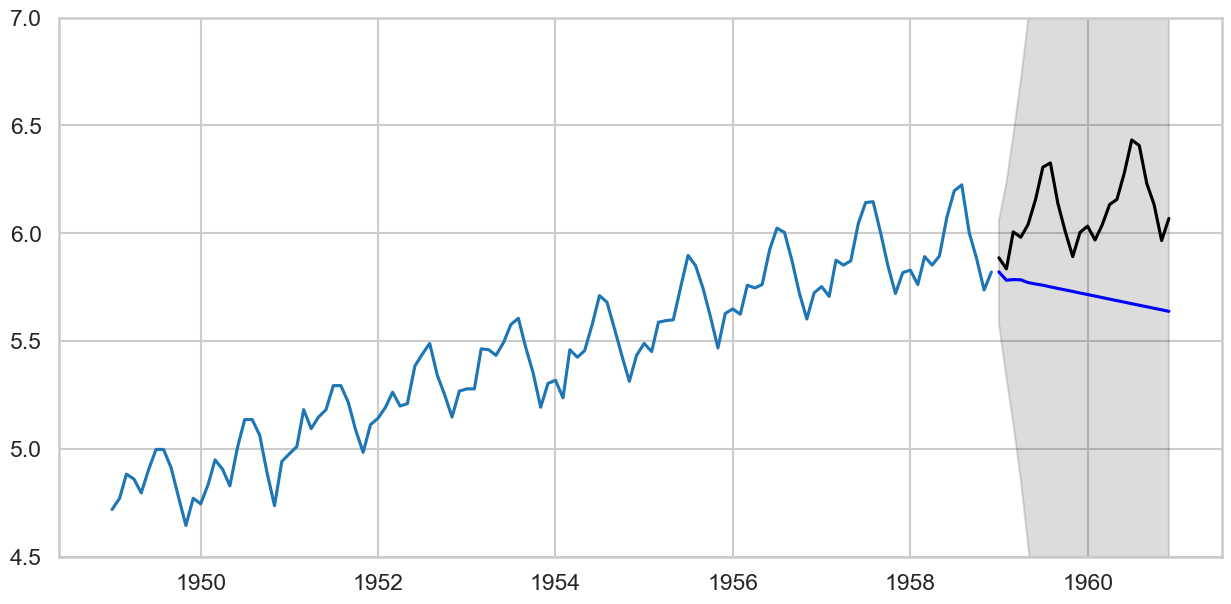

In [20]:
# Plot
plt.figure(figsize=(15,7))
plt.plot(train.log_passengers, color='#1f76b4')
plt.plot(test.log_passengers, color='black')
plt.plot(arima_preds, color='blue')    
# plt.plot(arima_preds, color='red')    
# plt.plot(fitted_series, color='darkgreen')
plt.fill_between(test.index, 
                arima_conf_int[:,0], 
                arima_conf_int[:,1], 
                color='k', alpha=.15)
plt.ylim([4.5,7])
plt.show()

#### SARIMA

In [21]:
# Create predictions for the future, evaluate on test
sarima_preds, sarima_conf_int = sarima.predict(n_periods=test.shape[0], return_conf_int=True)

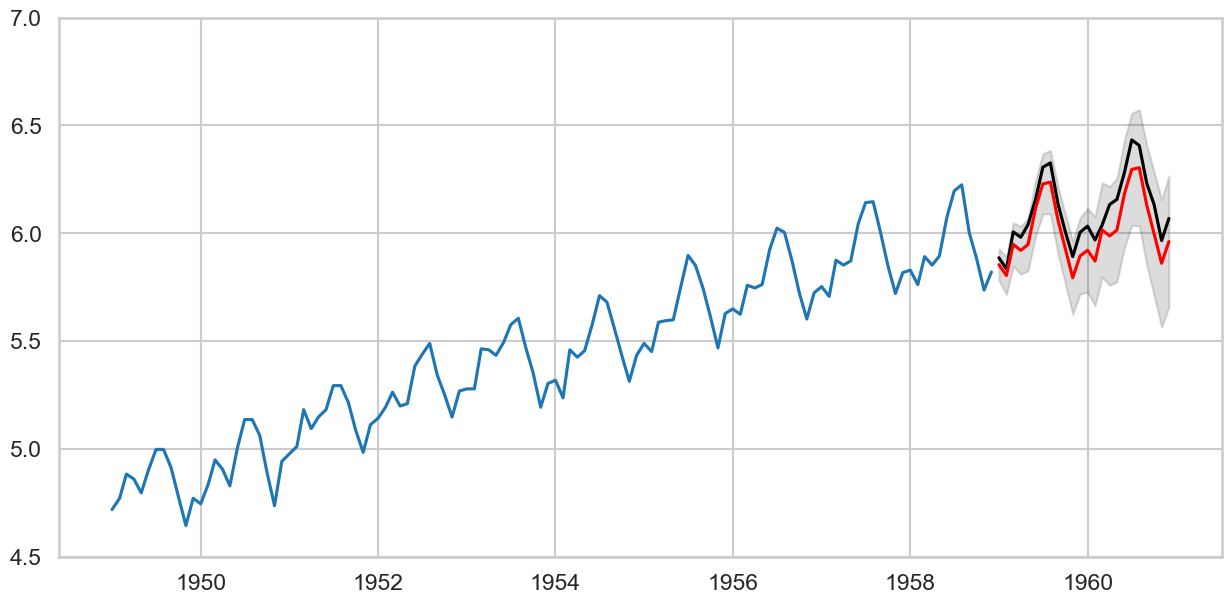

In [22]:
# Plot predictions (on log scale)
plt.figure(figsize=(15,7))
plt.plot(train.log_passengers, color='#1f76b4')
plt.plot(test.log_passengers, color='black')
plt.plot(sarima_preds, color='red')    
plt.fill_between(test.index, 
                sarima_conf_int[:,0], 
                sarima_conf_int[:,1], 
                color='k', alpha=.15)
plt.ylim([4.5,7])
plt.show()

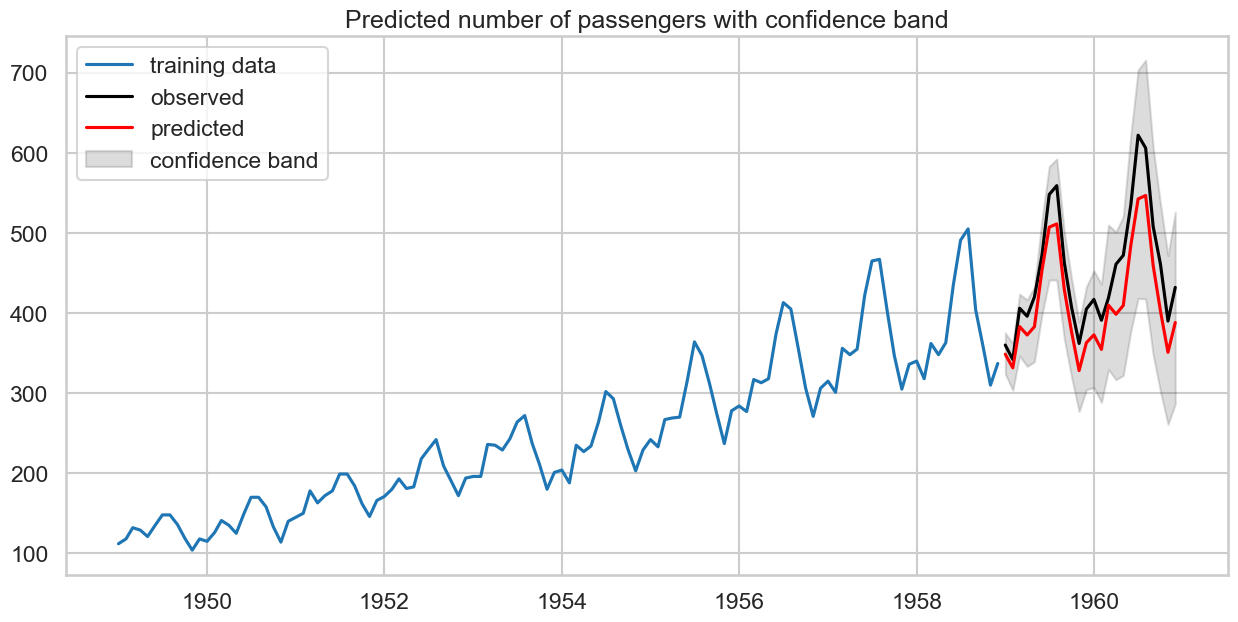

In [23]:
# Plot original series (logarithmicization reversed)
plt.figure(figsize=(15,7))
plt.plot(train.passengers, color='#1f76b4', label='training data')
plt.plot(test.passengers, color='black', label='observed')
plt.plot(np.exp(sarima_preds), color='red', label='predicted')  
plt.fill_between(test.index, 
                np.exp(sarima_conf_int[:,0]), 
                np.exp(sarima_conf_int[:,1]), 
                color='k', alpha=.15, label='confidence band')
plt.title('Predicted number of passengers with confidence band')
plt.legend(loc='upper left')
plt.show()

#### Mean Squared Error
The RMSE confirms that the SARIMA model obviously provides better predictions than the ARIMA model.

In [24]:
# RMSE for log_passengers
print("Test RMSE for ARIMA: %.3f" % np.sqrt(mean_squared_error(test.log_passengers, arima_preds)))
print("Test RMSE for SARIMA: %.3f" % np.sqrt(mean_squared_error(test.log_passengers, sarima_preds)))

Test RMSE for ARIMA: 0.424
Test RMSE for SARIMA: 0.096
